# 노드 제공 기본 모델

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

print(ROOT_PATH)

/aiffel/aiffel


In [3]:
# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10


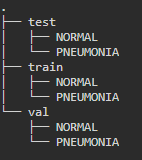

In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [6]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

# 처음 10개의 파일 경로만 출력
print("Shuffled filenames:\n" + "\n".join(filenames[:10]))

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg
Shuffled filenames:
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1026_bacteria_2957.jpeg
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person426_bacteria_1863.jpeg
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1361_virus_2344.jpeg
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0291-0001.jpeg
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person805_bacteria_2712.jpeg
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0566-0001.jpeg
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1317_bacteria_3332.jpeg
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1002-0001.jpeg
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0519-0001-0001.jpeg


In [7]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [10]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [11]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [14]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    # print(label)  # tf.Tensor(False, shape=(), dtype=bool)

Image shape:  (180, 180, 3)
Label:  False


In [15]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [16]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    # 데이터셋을 무작위로 섞어서 데이터 순서의 영향을 받지 않도록 함
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # 에포크가 끝나도 데이터셋이 계속 반복되도록 설정 (무한 반복)
    ds = ds.repeat()
    # 배치 단위로 데이터를 묶음 (여기서는 BATCH_SIZE로 지정된 크기만큼 묶음)
    ds = ds.batch(BATCH_SIZE)
    # 데이터를 미리 로드하여 학습 중에 GPU/CPU가 데이터를 기다리지 않도록 함
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# 학습용 데이터셋을 준비
train_ds = prepare_for_training(train_ds)
# 검증용 데이터셋을 준비
val_ds = prepare_for_training(val_ds)


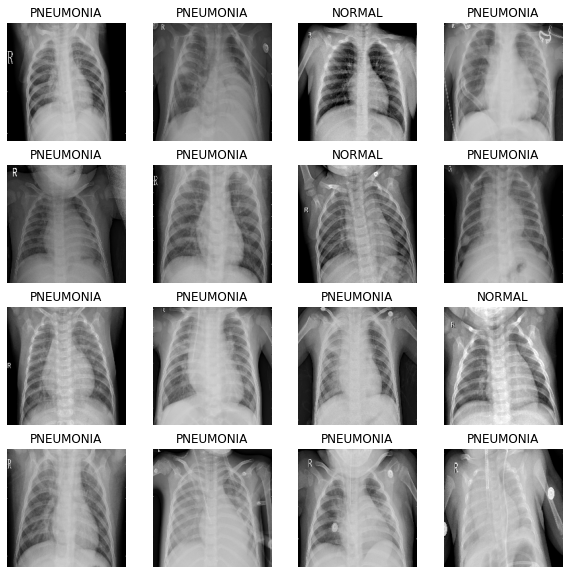

In [18]:
# 이미지 배치를 입력받아 여러 장의 이미지를 한 화면에 시각화하는 함수
def show_batch(image_batch, label_batch):
    # 10x10 크기의 빈 그림(figure)을 생성
    plt.figure(figsize=(10,10))
    
    # BATCH_SIZE만큼 반복하면서 이미지와 라벨을 각각 subplot에 그려줌
    for n in range(BATCH_SIZE):
        # 4행, (BATCH_SIZE/4)열의 grid에서 n+1번째 subplot을 생성
        ax = plt.subplot(4, math.ceil(BATCH_SIZE/4), n+1)
        
        # 각 배치의 이미지를 subplot에 그려줌
        plt.imshow(image_batch[n])
        
        # 라벨이 1이면 폐렴(PNEUMONIA), 0이면 정상(NORMAL)으로 타이틀 설정
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        
        # 축을 제거해서 이미지만 표시
        plt.axis("off")


# train_ds에서 첫 번째 배치 데이터를 가져옴 (이미지 배치와 라벨 배치)
image_batch, label_batch = next(iter(train_ds))

# 이미지와 라벨을 넘겨주어 배치 내 이미지를 시각화
show_batch(image_batch.numpy(), label_batch.numpy())


In [20]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        # Batch Normalization 레이어: 각 배치에서 입력을 정규화하여 학습 안정성을 높이고 Gradient Vanishing/Exploding 문제를 해결함
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

### **SeparableConv2D vs Conv2D 간단 비교**

|                      | **Conv2D**                          | **SeparableConv2D**                  |
|----------------------|-------------------------------------|--------------------------------------|
| **연산 방식**        | 모든 입력 채널에 대해 동시에 필터 적용 | 입력 채널별로 먼저 분리 후 1x1 필터로 결합 |
| **연산량**           | 연산 비용이 큼                        | 연산량이 적어 효율적                 |
| **모델 크기**        | 비교적 큼                            | 더 작은 모델 크기 가능               |
| **속도**             | 느림                                | 더 빠름                              |
| **성능**             | 복잡한 패턴 학습 성능이 뛰어남          | 복잡한 패턴 학습에선 성능이 낮을 수 있음 |
| **적용 예시**        | 일반 CNN 모델들                      | MobileNet 등 경량 모델에 사용         |

### **장단점 비교**

|                      | **Conv2D**                          | **SeparableConv2D**                  |
|----------------------|-------------------------------------|--------------------------------------|
| **장점**             | 더 복잡한 패턴을 잘 학습             | 연산량이 적어 효율적, 빠름, 경량화 가능 |
| **단점**             | 연산량이 많고 느림, 메모리 많이 사용  | 복잡한 패턴 학습 성능이 낮을 수 있음    |

이렇게 **Conv2D**는 복잡한 패턴 학습에 유리하지만,
**SeparableConv2D**는 연산 효율성을 높이고 경량화된 모델 설계에 강점을 가진다.

In [21]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        # 완전 연결층 (units 수만큼 뉴런을 생성하고 ReLU 활성화 함수 적용)
        tf.keras.layers.Dense(units, activation='relu'),  
        
        # Batch Normalization을 통해 학습 안정성 및 속도 향상
        tf.keras.layers.BatchNormalization(),
        
        # Dropout을 사용하여 과적합 방지
        tf.keras.layers.Dropout(dropout_rate)  
    ])
    
    return block

In [23]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [24]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [25]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [26]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 150s 395ms/step - loss: 0.3658 - accuracy: 0.8415 - precision: 0.9588 - recall: 0.8225 - val_loss: 0.7747 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 61s 233ms/step - loss: 0.2064 - accuracy: 0.9246 - precision: 0.9765 - recall: 0.9208 - val_loss: 1.3631 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 57s 220ms/step - loss: 0.2013 - accuracy: 0.9282 - precision: 0.9753 - recall: 0.9270 - val_loss: 0.1193 - val_accuracy: 0.9510 - val_precision: 0.9429 - val_recall: 0.9935
Epoch 4/10
261/261 [==============================] - 58s 224ms/step - loss: 0.1829 - accuracy: 0.9294 - precision: 0.9776 - recall: 0.9263 - val_loss: 0.3644 - val_accuracy: 0.8375 - val_precision: 0.8185 - val_recall: 1.0000
Epoch 5/10
261/261 [==============================] - 59s 227ms/step - loss: 0.1772 - accur

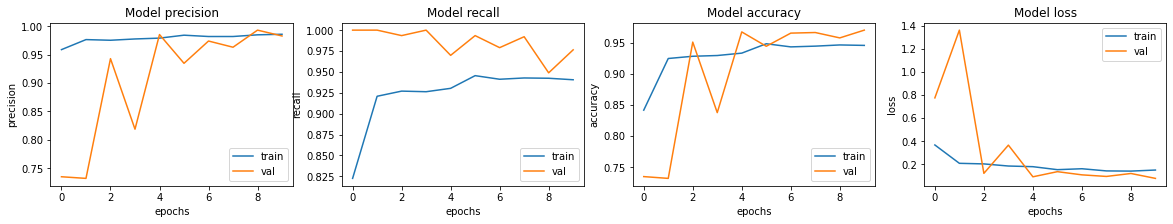

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [28]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 121ms/step - loss: 0.8542 - accuracy: 0.7708 - precision: 0.7352 - recall: 0.9897
Loss: 0.854248046875,
Accuracy: 0.7708333134651184,
Precision: 0.7352380752563477,
Recall: 0.9897435903549194


# ⚠️ 프로젝트: 폐렴 진단기 성능개선

In [140]:
import tensorflow
from tensorflow import keras

print(tensorflow.__version__)

2.6.0


## Step 1. 실험환경 Set-up
Batch size, Epoch 등을 변경.

### 💡 기본 제공된 모델에서 변경/추가된 점
(여러 모델 비교 목적이므로, 가독성 향상을 위해 model.fit 에 직접 기입)

## Step 2. 데이터 준비하기
원본 데이터를 가져와서 전처리 및 배치 구성을 진행.

### 💡 기본 제공된 모델에서 변경/추가된 점
- augment 추가
    - 좌우 반전
        - 좌우가 반전 되어도 폐렴 여부 판단에 손상 없을 듯.
            - 상하반전은 하지 않음: 일반적으로 생성될 수 없는 이미지이므로, 오히려 학습에 부정적인 영향을 미칠 수 있어 보임.
    - 밝기 조정, 대비 조정
        - 미미한 밝기/대비 변경은 폐렴 여부 판단에 지장 없을 듯.
        - 세부적인 차이를 더 잘 학습하여 폐렴 여부 판단에 도움 될 듯.
        - 범위를 5% 내외로 조정하여 이미지가 크게 변형되지 않도록 함.
        - 스케일링
            - 밝기/대비 조정 배율에 따라 이미지 값이 [0, 1] 범위를 초과하는 경우가 발생.
            - GPT는 자꾸만 tf.clip_by_value(image, 0.0, 1.0)을 추천하였으나, 그러면 패턴이 손상될 위험이 있음.
            - 패턴을 유지하기 위해서 최대 요소가 1보다 크면, 해당 값으로 나눴음.
        - clip_by_value
            - 위에서 스케일링을 했음에도, 알 수 없는 이유로 자꾸만 값이 초과되었다는 경고 메시지가 떠서 그냥 직접 clip 해줬음. 나중에 원인 파악 후 재 스케일링 시도할 것.
            
- prepare_for_training 구조 변경
    - augment 를 추가함으로써, ds.map 활용.
- input_shape 변수 추가
    - 추후에 residual_block 등의 함수에 활용하기 위함.

In [141]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우 반전
    image = tf.image.random_brightness(image, max_delta=0.05)  # 밝기 조정
    image = tf.image.random_contrast(image, lower=0.95, upper=1.05)  # 대비 조정
       
    # 최대값 기준으로 다시 0~1로 스케일링
    max_value = tf.reduce_max(image)
    if max_value > 1:
        image = image / max_value  # 최대값으로 나눠서 0~1 사이로 다시 스케일링

    # 스케일링 이후 값이 0~1을 벗어나지 않도록 클리핑
    image = tf.clip_by_value(image, 0.0, 1.0)


    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # 데이터 증강 적용
            num_parallel_calls=2        
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

input_shape = 0
for image, label in train_ds.take(1):
    input_shape = image.numpy().shape
    print("Image shape: ", input_shape)
    print("Label: ", label.numpy())
    # print(label)  # tf.Tensor(False, shape=(), dtype=bool)


train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)


Image shape:  (180, 180, 3)
Label:  False


## Step 3. 데이터 시각화
만약 augmentation을 시도했다면 이후 실습 코드에 있는 show_batch() 함수를 통해 실제로 좌우 반전 등이 제대로 처리되었는지 확인해 봅시다.

### 💡 기본 제공된 모델에서 변경/추가된 점
없음

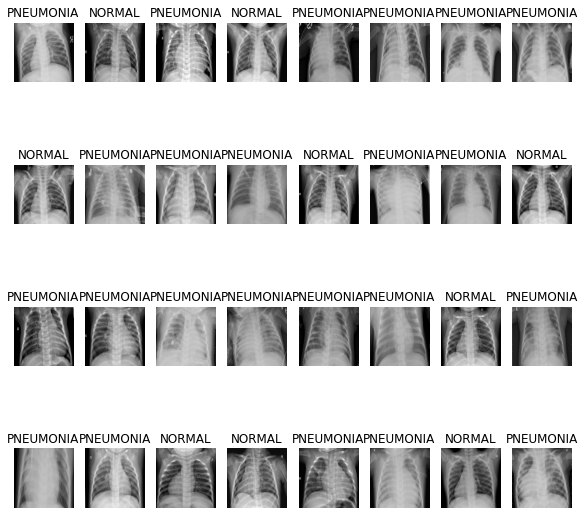

In [142]:
# train_ds에서 첫 번째 배치 데이터를 가져옴 (이미지 배치와 라벨 배치)
image_batch, label_batch = next(iter(train_ds))

# 이미지와 라벨을 넘겨주어 배치 내 이미지를 시각화
show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. ResNet-18 구현
의료 영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다. Convolution filter, 채널 개수, activation, 모델 구조 등을 다양하게 바꾸어볼 수 있습니다.

ResNet은 Residual block을 먼저 구성해야 합니다. ResNet에서의 weight layer는

3x3 CNN
BatchNormalization
활성화 함수 ReLU
로 구성되어 있습니다.

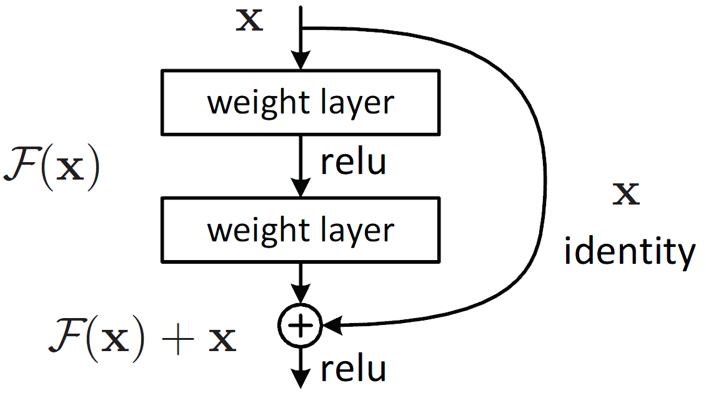

In [143]:
# 노드에서 제공한 샘플 코드.
# ⚠️ 참고용이므로, 사용하지 않음.
def conv_block_sample(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        # Batch Normalization 레이어: 각 배치에서 입력을 정규화하여 학습 안정성을 높이고 Gradient Vanishing/Exploding 문제를 해결함
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block


def residual_module_sample(input_layer, n_filters):
    merge_input = input_layer

    # if문에서는 채널 사이즈가 동일한지 확인하고, 만일 동일하지 않다면 1x1 convolution을 통해서 채널 사이즈를 맞춰 준다.
    if input_layer.shape[-1] != n_filters:
        merge_input = keras.layers.Conv2D(n_filters, (1,1), padding='same', activation='relu')(input_layer) # n_filter로 채널 사이즈를 맞춰 준다.
    # Conv2D layer
    conv1 = keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(input_layer)
    # Conv2D layer
    conv2 = keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='linear')(conv1)

    # Add를 통해서 skip connection을 구현하는 부분
    out_layer = keras.layers.Add()([conv2, merge_input])
    out_layer = keras.layers.Activation('relu')(out_layer)

    return out_layer

### 💡 기본 제공된 모델에서 변경/추가된 점

- SeparableConv2D -> Conv2D
    - GPT의 비교
        - 모델을 경량화하고 싶다면: SeparableConv2D를 고려할 수 있음. 하지만 일부 성능 손실이 있을 수 있음.
        - 최고의 성능을 원한다면: Conv2D를 사용하는 것이 더 적합함. ResNet-18에서는 특히 복잡한 패턴을 잘 학습할 수 있기 때문에, 이 방식이 더 권장됨.
    - ResNet-18의 경우는 복잡한 패턴을 학습하고, 깊이 있는 네트워크를 구성하는 것이 목적이므로 **Conv2D**를 사용.
    - 정확도를 조금이라고 끌어올리기 위해 성능을 중시하였음.


In [144]:
def residual_block(input_layer, n_filters, strides=1):
    merge_input = input_layer

    # 입력 텐서와 출력 텐서의 크기가 다를 경우 1x1 Conv2D로 크기 맞추기
    if input_layer.shape[-1] != n_filters or strides != 1:
        merge_input = keras.layers.Conv2D(n_filters, (1, 1), padding='same', strides=strides, activation=None)(input_layer)
        merge_input = keras.layers.BatchNormalization()(merge_input)

    # 첫 번째 Conv2D + BatchNorm + ReLU
    conv1 = tf.keras.layers.Conv2D(n_filters, (3, 3), strides=strides, padding='same')(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    # 두 번째 Conv2D + BatchNorm
    conv2 = tf.keras.layers.Conv2D(n_filters, (3, 3), padding='same')(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)

    # Skip connection을 더함
    out_layer = keras.layers.Add()([conv2, merge_input])
    out_layer = keras.layers.ReLU()(out_layer)

    return out_layer


위에 있는 그림대로 Residual block을 구성했다면 이제는 아래 그림을 보고 ResNet을 구현해주세요

(참고사항 : 해당 table은 ImageNet Challenge를 가정했기 때문에 filter개수는 튜닝하면서 바꿔주세요!)

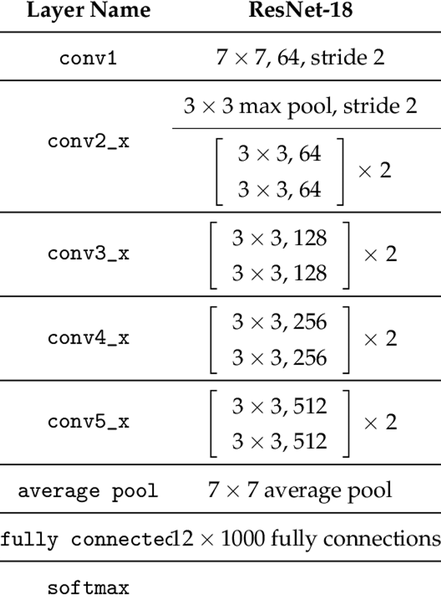

### 💡 기본 제공된 ResNet-18 모델에서 변경/추가된 점
- Output layer: Dense(1, activation='sigmoid')
    - softmax 가 아닌 sigmoid
        - 어차피 폐렴/정상이므로, 이진 분류 문제임.
    - num_classes = 1
        - 이진 분류니까.
- Dropout 추가
    - 세밀한 특징 학습을 위해, adam의 learning rate를 0.0005로 줄였음.
    - 일반적으로 Global Average Pooling 후 Fully Connected layer 바로 앞에 적용하는 것이 효과적이므로, 해당 위치에 구현.
    - 50% 확률로만 적용했음. learning rate를 반절로 줄였기 때문. 단, 이게 딱 떨어지는 비율 설정인지는 사실 테스트 전까지는 모르겠음.

In [149]:
def build_resnet18(input_shape, num_classes=1):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial convolution and max-pooling
    x = keras.layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Residual blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128)
    x = residual_block(x, 128)

    x = residual_block(x, 256)
    x = residual_block(x, 256)

    x = residual_block(x, 512)
    x = residual_block(x, 512)

    # Global Average Pooling + fully connected layer
    x = keras.layers.GlobalAveragePooling2D()(x)
    
    # Adam learning rate를 0.001 -> 0.0005로 변경할 예정.
    # 그러므로, 과적합 방지 필요.
    x = keras.layers.Dropout(0.5)(x)

    outputs = keras.layers.Dense(num_classes, activation='sigmoid')(x)

    # 모델 구성
    model = keras.Model(inputs, outputs)

    return model


# 모델 생성
# model = build_resnet18(input_shape, num_classes=1)


with tf.device('/GPU:0'):
    model = build_resnet18(input_shape, num_classes=1)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=METRICS
    )

### ⚠️ train_ds 나 val_ds가 build_resnet18 의 input으로 안 들어가도 된다!
- build_resnet18 함수는 모델의 구조를 정의하는 함수임. 이 함수에서는 데이터셋을 직접 다루지 않고, 모델의 **입력 크기(input_shape)**와 출력 크기(num_classes) 같은 정보만 필요함.
- 데이터셋(즉, train_ds와 val_ds)은 모델 학습 단계에서 fit 함수로 전달돼야 함. build_resnet18은 그저 네트워크의 구조를 정의할 뿐이고, 데이터셋과는 별개의 과정임.

### 💡 Adam을 그대로 사용하는 이유
- Adam = 빠른 수렴(RMSprop) + 적응적 학습률(SGD with Momentum)
    - 그러므로, 의료 데이터셋에서 안정적인 학습 성능을 제공하기 가장 좋은 가성비 옵티마이저임.
    - 단, 과적합 주의.
        - dropout(0.5) 적용했으니 해결 완료...? 잘 모르겠다.

### 💡 기본 제공된 ResNet-18 모델에서 변경/추가된 점
- learning rate: 0.001 -> 0.0005
    - 더욱 세밀한 학습을 하여 정답률을 높이기 위함.
    - 과적합 방지를 위해 구현한, '데이터 증강' 및 'Dropout'의 효과가 충분히 있을 것이라고 가정했음.

In [150]:
# 모델 구조 확인
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_211 (Conv2D)             (None, 90, 90, 64)   9472        input_21[0][0]                   
__________________________________________________________________________________________________
batch_normalization_236 (BatchN (None, 90, 90, 64)   256         conv2d_211[0][0]                 
__________________________________________________________________________________________________
re_lu_192 (ReLU)                (None, 90, 90, 64)   0           batch_normalization_236[0][0]    
___________________________________________________________________________________________

## Step 5. 데이터 imbalance 처리
실습 코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었습니다. 만약 이러한 처리를 생략한다면 어떻게 될까요? 또 recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?



## Step 6. 모델 훈련
loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.



### 💡 기본 제공된 ResNet-18 모델에서 변경/추가된 점
- BATCH_SIZE = 32  # 16->32
- EPOCHS = 12  # 10->12

In [151]:
from tensorflow.keras.callbacks import EarlyStopping

# 조기 종료 설정 (검증 손실이 3번 연속으로 개선되지 않으면 학습 중단)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# 모델 학습
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[early_stopping]
    )

Epoch 1/12
130/130 [==============================] - 111s 773ms/step - loss: 0.2718 - accuracy: 0.8959 - precision: 0.9658 - recall: 0.8919 - val_loss: 4.2873 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 2/12
130/130 [==============================] - 100s 773ms/step - loss: 0.1759 - accuracy: 0.9351 - precision: 0.9783 - recall: 0.9334 - val_loss: 5.2407 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 3/12
130/130 [==============================] - 100s 769ms/step - loss: 0.1717 - accuracy: 0.9404 - precision: 0.9814 - recall: 0.9377 - val_loss: 1.9161 - val_accuracy: 0.7461 - val_precision: 0.7433 - val_recall: 1.0000
Epoch 4/12
130/130 [==============================] - 100s 772ms/step - loss: 0.1490 - accuracy: 0.9435 - precision: 0.9834 - recall: 0.9398 - val_loss: 3.6812 - val_accuracy: 0.7295 - val_precision: 0.7295 - val_recall: 1.0000
Epoch 5/12
130/130 [==============================] - 100s 769ms/step - loss: 0.1481 - a

## Step 7. 결과 확인과 시각화

테스트 데이터로 훈련된 모델을 평가해 봅시다. 우선은 accuracy를 고려해야겠지만 의료 영상 모델의 특성상 recall도 중요합니다. 훈련과정의 history 그래프를 시각화해 보고, 학습 진행 양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.

## 새 모델 성적

39/39 [==============================] - 6s 133ms/step - loss: 5.7415 - accuracy: 0.3830 - precision: 1.0000 - recall: 0.0128
Loss: 5.7415080070495605,
Accuracy: 0.3830128312110901,
Precision: 1.0,
Recall: 0.012820512987673283


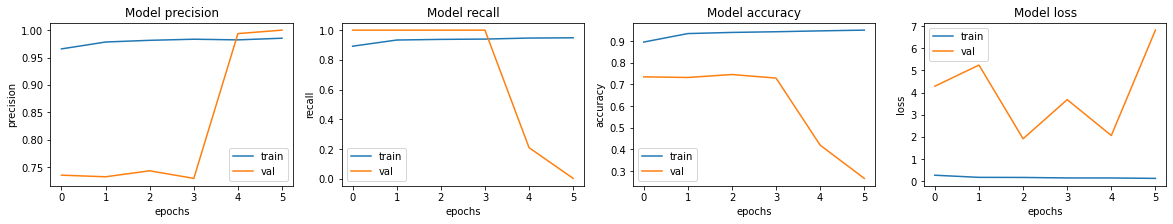

In [152]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

- Loss: 5.741
- Accuracy: 0.383
- Precision: 1.0
- Recall: 0.0128


## 기존 모델 성적

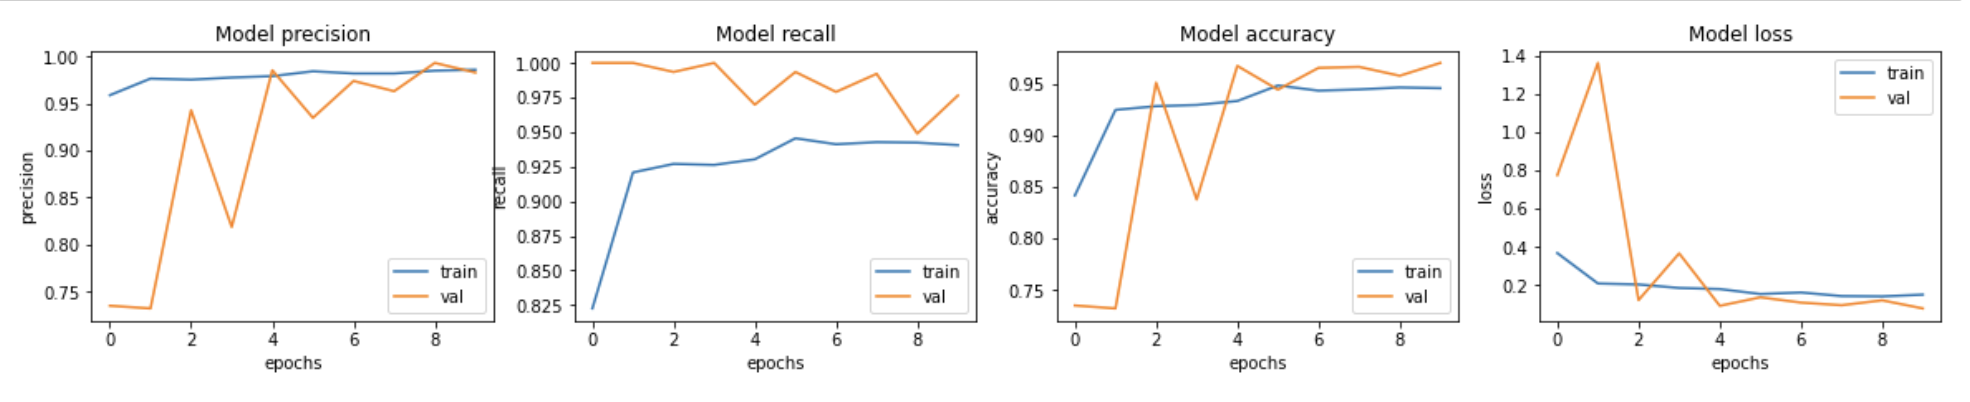

- Loss: 0.854
- Accuracy: 0.770
- Precision: 0.735
- Recall: 0.989

# 보고서

## 채점 기준 (총 5점)
- 프로젝트 제출 : 1점
- 루브릭 : 4점
    - 의료영상을 처리하는 CNN 기반 베이스 모델이 잘 구현되었다 1점
        - 아마 완료한 듯...?
            - 성적이 크게 다르지 않은 걸 보면.
    - 데이터 augmentation 기법을 사용해서 베이스 모델과의 성능을 비교 - 1점
        - 완료.
            - 증강 및 Dropout 적용한 모델로 성적 비교.
    - 모델 구조 변경을 통해 베이스 모델과의 성능 비교 - 1점
        - 완료.
            - 정확도 향상 및 최적화 등을 위해 많이 노력했음.
    - ResNet-18 모델을 구현하고 학습 성공 - 1점
        - 개조된 ResNet-18 모델이긴 하지만... 학습은 성공.
            - 물론, 훌륭한 학습이었는가는 별개로 ㅎㅎ


---
## Summary

⚠️ 검증 손실이 3번 연속으로 개선되지 않아서, 학습이 중단되었다. 😭

### 1. **성능 비교**  
| **Metric**             | **Before**     | **After**      |
|------------------------|----------------|----------------|
| **Loss**               | 0.8542         | 5.7415         |
| **Accuracy**           | 0.7708         | 0.3830         |
| **Precision**          | 0.7352         | 1.0000         |
| **Recall**             | 0.9897         | 0.0128         |

---

### 2. **문제 분석**
- **Loss 증가**: After 결과에서 Loss가 크게 증가한 것은 모델이 학습을 제대로 수행하지 못한 것으로 해석된다.
- **Accuracy 감소**: Accuracy는 77.08%에서 38.30%로 하락했으며, 이는 모델이 검증 데이터에 대한 예측 성능이 크게 떨어졌음을 의미한다.
- **Precision 100% & Recall 1.28%**: Precision이 100%로 나온 것은 모든 양성 예측이 정확했음을 나타내지만, Recall이 매우 낮다는 것은 모델이 대부분의 양성 데이터를 예측하지 못하고 있음을 시사한다. 이는 **불균형한 예측**이 발생했음을 의미한다.

---

### 3. **개선 방안 by GPT**
1. **학습률(Learning Rate) 조정**  
   현재 설정된 Learning Rate(0.0005)를 **0.001**로 증가시켜, 모델이 적절하게 가중치를 업데이트할 수 있도록 조정한다. 너무 낮은 학습률은 학습을 저해할 수 있다.
    - 그냥 0.001로 놔둘 걸...

2. **과적합 방지 기법 적용**  
   - **Dropout**: 과적합을 방지하기 위해 Dropout을 추가한다. 예를 들어, Global Average Pooling 후에 50%의 Dropout을 적용하여 학습 시 일부 뉴런을 무작위로 비활성화함으로써 모델이 데이터에 과도하게 의존하지 않도록 한다.
       - 이미 사용했지만...
   - **Regularization**: 가중치에 정규화를 적용하여 모델 복잡도를 낮추고 과적합을 방지한다.

3. **Class Weights 적용**  
   Recall이 낮은 이유는 데이터 불균형 문제일 수 있다. 양성 클래스(1)에 가중치를 부여하여 모델이 불균형 데이터에 대해 더 잘 학습할 수 있도록 조정한다.
    - 기본 제공 값으로는 부족했던 걸까?

4. **Early Stopping**  
   Early Stopping을 도입하여 검증 성능이 향상되지 않을 때 학습을 조기에 종료한다. 이를 통해 불필요한 과적합을 방지할 수 있다.
    - 덕분에 시간 낭비를 덜었다.

5. **데이터 증강 강화**  
   데이터 증강 기법을 강화하여 학습 데이터의 다양성을 높인다. 랜덤 회전, 밝기 조정, 좌우 반전 등을 추가하여 과적합을 방지하고 일반화 성능을 향상시킬 수 있다.
    - 해봤는데.. 잘못 했나?

---

### 4. **결론**
모델의 성능 저하는 과적합 및 데이터 불균형의 가능성을 시사한다. 이를 해결하기 위해서는 학습률 조정, 과적합 방지 기법 적용, Class Weights 설정, 그리고 데이터 증강을 통한 학습 데이터 다양성 확보가 필요하다.

---
## 회고
- 코드 구현을 직접 해본 경험이 너무 적다 보니, 이미 제공된 코드를 필요에 맞게 뜯어고치는 것도 너무 힘들었다. GPT 의존도가 거의 70% 이상이었던 것 같다.
    - 그래도 다행인 것은, 계속 코드를 보다 보니 어느 정도 구조가 익숙해져서, GPT가 자꾸만 놓치는 부분을 내가 어느정도 지적할 수 있게 되었다는 점이다.

- 다음부터는 일단 새로 만든 모델이 정상적으로 작동되는지부터 먼저 테스트 해보고, 이후에 하이퍼파라미터를 조정하든 말든 해야겠다. 하이퍼파라미터를 어떻게 조절하면 좋을지 계속 GPT 및 구글과 씨름하다 보니, 시간이 다 가버렸다.

- 시간이 더욱 충분했다면,
    - 다양한 방식으로 실험해보았을텐데...
        - 내가 구축한 새로운 모델은 두 번밖에 돌려보지 못했다. 계속 쏟아져나오는 수많은 오류들을 고치면서 모델 구현하느라 여유 시간을 전부 소모해버린 게 너무 아쉽다.
    - 모델을 제대로 구현했을텐데...
        - 결국 모델을 완전히 잘못 구현하여, 최악의 성적을 받아버렸다. 50% 보다 낮은 정확도라니ㅋㅋㅋ 이런...
        - 모델을 한 번 더 돌려볼 시간조차도 부족하여, 어디서부터 어떻게 잘못된 건지 알아볼 수도 없이 당장 제출해야하는 이 상황이 참 고통스럽다.

- 여태까지는 LMS를 통해 '빈칸 채우기'만 해왔기 때문에 '뜬구름 잡는 느낌'이 강했지만, 이번에 GPT의 도움은 받았을지언정 직접 온갖 코드를 씹고 뜯고 맛보고 즐겨본 덕분에, 휴일 여가시간을 활용하여 노드 내용을 복습하면 충분히 혼자서도 모델을 학습시켜볼 수 있을 것 같다는 자신감이 생겼다. 물론, 근거는 없다.


---
## Reference
- LMS 기본 제공 코드
- GPT-4o